In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)

In [27]:
dataset_path = "./data/[Data]_Ex2_NonLinear_data.npy"
dataset = np.load(dataset_path, allow_pickle=True).item()
X, y = dataset["X"], dataset["labels"]

print(X.shape)
print(X[:5])
print(y[:5])

(300, 2)
[[0.         0.        ]
 [0.00096008 0.01005528]
 [0.01045864 0.01728405]
 [0.00087922 0.03029027]
 [0.00991727 0.03916803]]
[0 0 0 0 0]


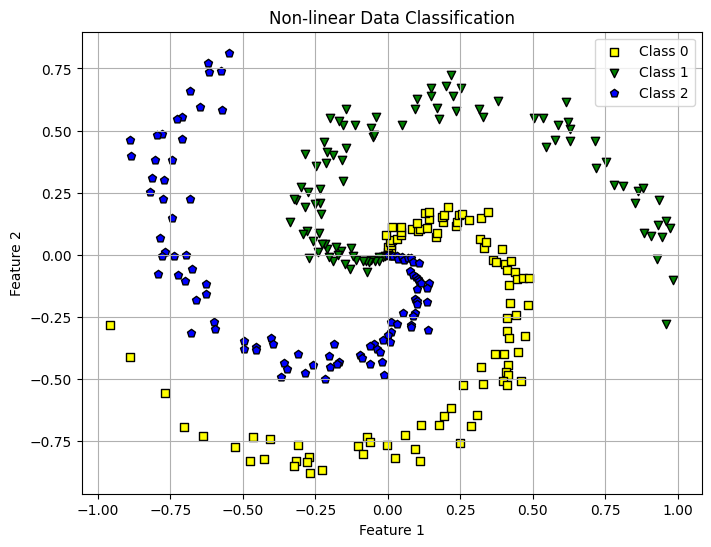

In [28]:
# Read dataset and visualize
colors = ["yellow", "green", "blue"]
markers = ["s", "v", "p"]

plt.figure(figsize=(8, 6))
for i, class_label in enumerate(np.unique(y)):
    plt.scatter(
        X[y == class_label, 0],
        X[y == class_label, 1],
        c=colors[i],
        marker=markers[i],
        label=f"Class {class_label}",
        edgecolors="k",
    )

plt.title("Non-linear Data Classification")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle
)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle
)

print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of test samples: {X_test.shape[0]}")
print(f"Number of val samples: {X_val.shape[0]}")

Number of training samples: 210
Number of test samples: 30
Number of val samples: 60


In [30]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)
X_val = normalizer.transform(X_val)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


In [31]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]


batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [32]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [33]:
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 128
lr = 1e-1

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [34]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

In [ ]:
# Training
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs)
        train_target.append(y_samples)
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()
            val_predict.append(outputs)
            val_target.append(y_samples)

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_predict = torch.cat(val_predict)
        val_target = torch.cat(val_target)

        val_acc = compute_accuracy(val_predict, val_target)
        val_accs.append(val_acc)

Text(0.5, 1.0, 'Validation Accuracy')

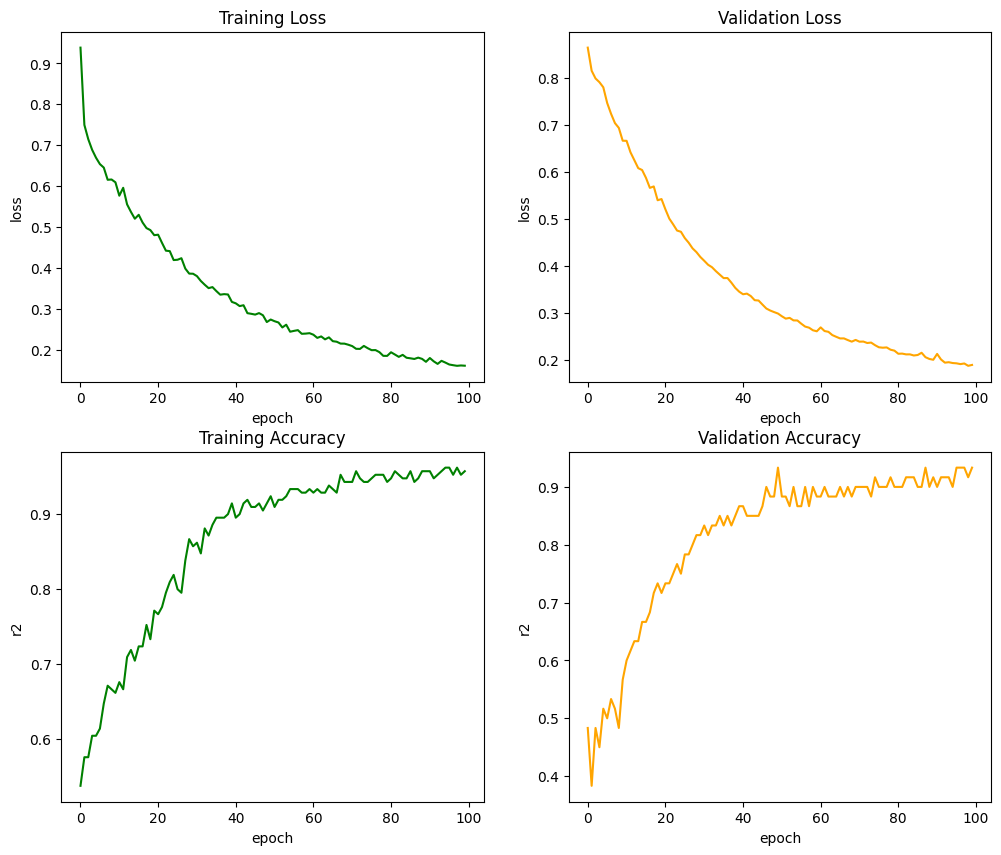

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color="green")
ax[0, 0].set(xlabel="epoch", ylabel="loss")
ax[0, 0].set_title("Training Loss")

ax[0, 1].plot(val_losses, color="orange")
ax[0, 1].set(xlabel="epoch", ylabel="loss")
ax[0, 1].set_title("Validation Loss")

ax[1, 0].plot(train_accs, color="green")
ax[1, 0].set(xlabel="epoch", ylabel="r2")
ax[1, 0].set_title("Training Accuracy")

ax[1, 1].plot(val_accs, color="orange")
ax[1, 1].set(xlabel="epoch", ylabel="r2")
ax[1, 1].set_title("Validation Accuracy")